# Прогнозирование срока поиска с использованием  Lasso-регуляризации

### 1. Загрузка и предобработка данных

In [58]:
!pip install catboost
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

In [59]:
data = pd.read_csv('/content/data.csv')
data = data.dropna()
data.head() #читаем данные

,Наименование королевства,Наименование земли,Наименование хребта,Наименование расщелины,Цель,Тип расщелины,Категория расщелины,Назначение расщелины,Участки,Тип отвилка,...,Количество простоев по зельям,Количество простоев в контроле поиска,Количество простоев в конце расщелины,Количество простоев по долбилам,Количество простоев по вине исследователей,Количество простоев по креплениям,Количество простоев (прочие),Общий путь поиска,Дата начала поиска,Дата окончания поиска
1828,Кэдвен,Орехвал,1916,1701,поиск,наклонная,Поисковая,Око Дракона,среднее укрепление+основное укрепление,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4424.40,2164-11-22 02:00:17,2164-12-15 05:00:17
1843,Темерия,Вингар,444,3011,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+пилот+ос...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5334.30,2164-10-27 12:00:17,2164-12-23 00:00:17
1885,Темерия,Итурия,1246,2795,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+основное...,Материнский,...,0.0,0.0,0.0,0.0,0.0,0.9,0.0,5537.70,2164-11-19 08:00:17,2165-01-09 10:00:17
1886,Зеррикания,Мессоя,923,731,поиск,горизонтальная,Нагнетательная,Магическое воздействие,среднее укрепление+пилот,Материнский,...,0.9,0.0,0.0,0.0,0.0,0.9,0.0,2362.95,2164-12-02 03:30:17,2165-01-10 04:30:17
1887,Темерия,Грейтвуд,7233,2198,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+тупик,Материнский; Пилотный,...,0.0,0.0,0.0,0.0,0.0,0.0,0.9,6282.00,2164-12-03 17:00:17,2165-01-12 00:00:17


### 2. Преобразование и создание целевой переменной
Преобразуем данные начала и окончания поиска в формат datetime и создаем целевую переменную – "Срок поиска (дней)".

In [60]:
# Преобразование дат начала и окончания поиска в datetime формат
data['Дата начала поиска'] = pd.to_datetime(data['Дата начала поиска'], errors='coerce')
data['Дата окончания поиска'] = pd.to_datetime(data['Дата окончания поиска'], errors='coerce')

# Создание целевой переменной "Срок поиска (дней)" как разница между датой окончания и начала поиска
data['Срок поиска (дней)'] = (data['Дата окончания поиска'] - data['Дата начала поиска']).dt.days

# Удалим столбца с датами на чала и конца поиска
data = data.drop(columns=['Дата начала поиска', 'Дата окончания поиска'])


### 3. Анализ и кодирование категориальных данных
Анализируем категориальные признаки и удаляем неинформативные. Применяем One-Hot Encoding и Label Encoding для кодирования.

In [61]:
# Фильтруем нечисловые колонки
non_numeric_columns = data.select_dtypes(include=['object']).columns

# Считаем количество уникальных значений и пропущенных значений для каждой нечисловой колонки
non_numeric_info = {
    'Колонка': [],
    'Уникальных значений': [],
    'Пропущенных значений': []
}

for column in non_numeric_columns:
    non_numeric_info['Колонка'].append(column)
    non_numeric_info['Уникальных значений'].append(data[column].nunique())
    non_numeric_info['Пропущенных значений'].append(data[column].isnull().sum())

# Создаем DataFrame с информацией
non_numeric_info_df = pd.DataFrame(non_numeric_info)

# Выводим таблицу
print("Анализ нечисловых колонок:")
print(tabulate(non_numeric_info_df, headers='keys', tablefmt='pretty'))

Анализ нечисловых колонок:
+----+----------------------------------+---------------------+----------------------+
|    |             Колонка              | Уникальных значений | Пропущенных значений |
+----+----------------------------------+---------------------+----------------------+
| 0  |     Наименование королевства     |         10          |          0           |
| 1  |        Наименование земли        |         79          |          0           |
| 2  |       Наименование хребта        |         286         |          0           |
| 3  |               Цель               |          3          |          0           |
| 4  |          Тип расщелины           |          4          |          0           |
| 5  |       Категория расщелины        |          6          |          0           |
| 6  |       Назначение расщелины       |          3          |          0           |
| 7  |             Участки              |         38          |          0           |
| 8  |          

In [62]:
# Удаление 'Переименования данных' из набора данных
data = data.drop(columns=['Наименование хребта', 'Наименование расщелины', 'Наименование земли' ])

In [63]:
# Применение One-Hot Encoding и Label Encoding на основе рекомендаций

# One-Hot Encoding для выбранных признаков
one_hot_columns = [
    'Наименование королевства', 'Цель', 'Тип расщелины', 'Категория расщелины',
    'Назначение расщелины', 'Статус поиска'
]
data = pd.get_dummies(data, columns=one_hot_columns, drop_first=True)

# Label Encoding для остальных категориальных признаков с высокой мощностью
label_encode_columns = [
    'Участки', 'Тип отвилка', 'Технологическая особенность',
    'Помощник по контролю поиска', 'Помощник по поиску', 'Помощник по наклонным расщелинам',
    'Помощник по зельям', 'Помощник по долбилам', 'Помощник по исследованиям',
    'Помощник по укреплению', 'Помощник по огненным заклятиям', 'Помощник по подвескам',
    'Помощник по вырезке окна', 'Тип инструмента'
]

# Применение Label Encoding к выбранным столбцам
label_encoders = {}
for col in label_encode_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # Преобразование в строку в случае значений NaN
    label_encoders[col] = le  # Сохраняем кодирование

# Отображение первых нескольких строк набора данных для проверки кодировки
data.head()


,Участки,Тип отвилка,Технологическая особенность,Помощник по контролю поиска,Помощник по поиску,Помощник по наклонным расщелинам,Помощник по зельям,Помощник по долбилам,Помощник по исследованиям,Помощник по укреплению,...,Тип расщелины_горизонтальная,Тип расщелины_многощельная,Тип расщелины_наклонная,Категория расщелины_Нагнетательная,Категория расщелины_Пилот,Категория расщелины_Поисковая,Категория расщелины_Поисково-оценочная,Категория расщелины_Разведочная,Назначение расщелины_Магическое воздействие,Назначение расщелины_Око Дракона
1828,26,7,65,13,45,24,20,16,0,17,...,False,False,True,False,False,True,False,False,False,True
1843,15,7,22,4,37,85,6,1,4,13,...,True,False,False,False,False,True,False,False,False,True
1885,8,7,12,13,35,85,10,33,4,13,...,True,False,False,False,False,True,False,False,False,True
1886,31,7,21,8,12,18,2,12,21,23,...,True,False,False,True,False,False,False,False,True,False
1887,21,8,22,5,40,89,27,33,2,47,...,True,False,False,False,False,True,False,False,False,True


### 4. Анализ корреляций
Построим тепловую карту корреляции для оценки зависимости признаков от целевой переменной.

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Вычисляем VIF для каждого признака
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Признак"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Применение VIF к данным
vif_data = calculate_vif(data_filtered.drop(columns=["Срок поиска (дней)"]))  # Убираем целевую переменную
print(vif_data)

                        Признак        VIF
0  Общее время активного поиска   4.561466
1            Общее время поиска  20.669793
2          Общее время простоев   5.575756
3  Количество простоев в поиске  38.927838
4           Количество ремонтов  18.648323
5           Количество простоев   9.154223
6             Общий путь поиска   7.746792


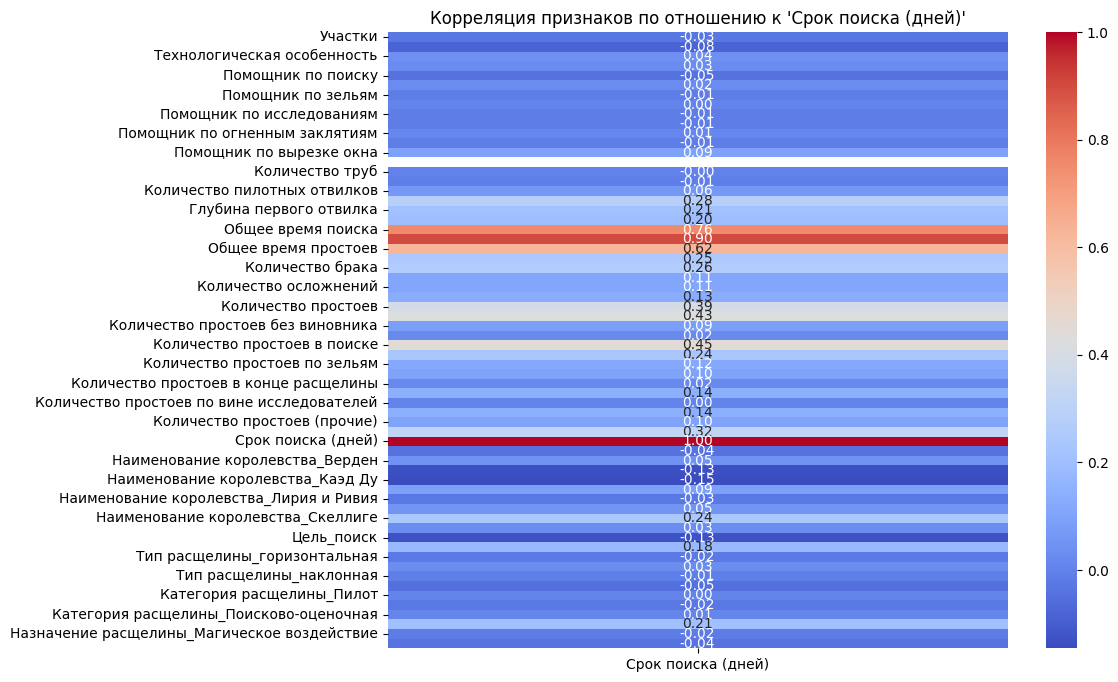

In [66]:
# Построение тепловой карты для визуализации корреляции выбранных объектов с признаком "Срок поиска (дней)"
corr_matrix = data.corr()
target_corr = corr_matrix[['Срок поиска (дней)']]  # Только с целевым признаком
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция признаков по отношению к 'Срок поиска (дней)'")
plt.show()

In [67]:
# Пересчитываем корреляционную матрицу для текущего набора данных
correlation_matrix = data.corr()

# Извлекаем корреляции признаков с целевой переменной "Срок поиска (дней)"
target_correlation = correlation_matrix["Срок поиска (дней)"].sort_values(ascending=False)

# Фильтруем признаки с высокой корреляцией (>0.3 или <-0.3) с целевой переменной "Срок поиска (дней)"
# Оставляем только те столбцы, которые есть в текущем наборе данных
high_corr_features = [col for col in target_correlation.index if abs(target_correlation[col]) > 0.3 and col in data.columns]

# Оставляем в наборе данных только признаки с высокой корреляцией
data = data[high_corr_features]

# Отображаем первые несколько строк отфильтрованного набора данных с признаками высокой корреляции
data.head()

,Срок поиска (дней),Общее время активного поиска,Общее время поиска,Общее время простоев,Количество простоев в поиске,Количество ремонтов,Количество простоев,Общий путь поиска
1828,23,19.76,20.82,1.05,1.8,1.8,0.0,4424.40
1843,56,46.33,50.85,0.14,1.8,2.7,0.0,5334.30
1885,51,43.39,45.97,2.59,6.3,1.8,2.7,5537.70
1886,39,23.71,35.14,10.05,36.9,14.4,37.8,2362.95
1887,39,34.60,25.11,0.76,0.0,0.0,1.8,6282.00


### 5. Отбор признаков
Оставляем признаки с корреляцией > 0.3 или < -0.3 относительно целевой переменной.

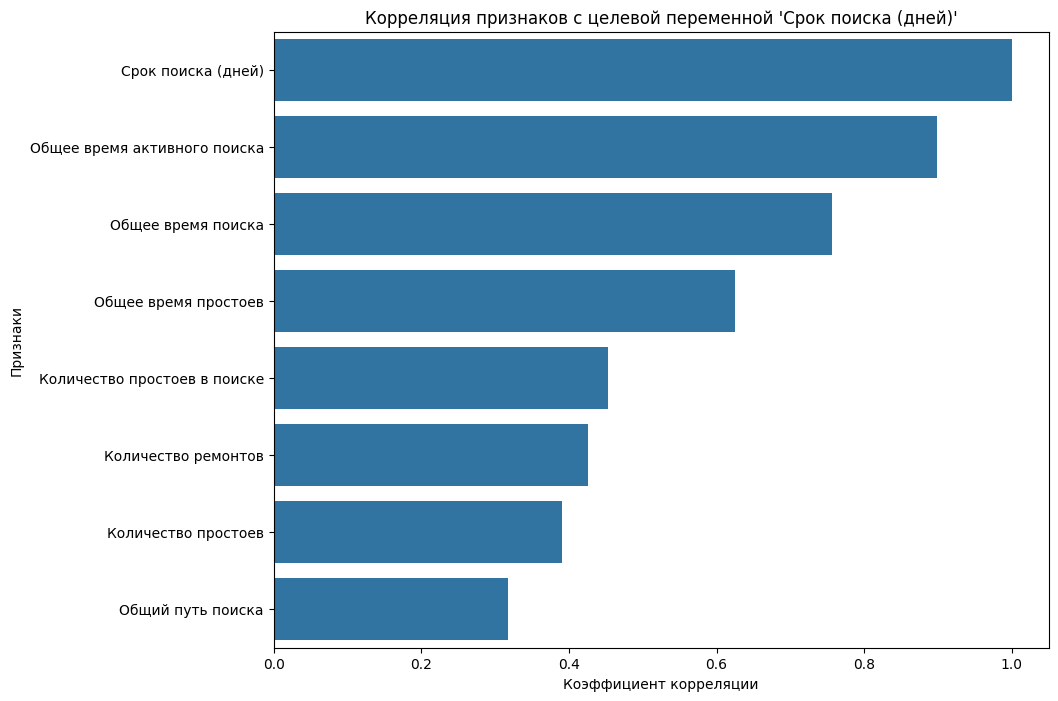

In [68]:
# Вычисляем корреляционную матрицу
correlation_matrix = data.corr()

# Извлекаем корреляции признаков с целевой переменной "Срок поиска (дней)"
target_correlation = correlation_matrix["Срок поиска (дней)"].sort_values(ascending=False)

# Построение графика для признаков с наибольшей корреляцией с целевой переменной
plt.figure(figsize=(10, 8))
sns.barplot(y=target_correlation.index[:30], x=target_correlation.values[:30])  # Отображаем топ-30 корреляций
plt.title("Корреляция признаков с целевой переменной 'Срок поиска (дней)'")  # Устанавливаем заголовок графика
plt.xlabel("Коэффициент корреляции")  # Подписываем ось X
plt.ylabel("Признаки")  # Подписываем ось Y
plt.show()

# Выводим первые 10 признаков с наибольшей корреляцией с целевой переменной
target_correlation.head(10)

# Устанавливаем порог корреляции (оставляем признаки с корреляцией > 0.3 или < -0.3)
high_corr_features = target_correlation[abs(target_correlation) > 0.3].index

# Создаем новый набор данных, содержащий только признаки с высокой корреляцией и целевую переменную
data_filtered = data[high_corr_features]

### 6. Ансаблевая модель
Используем анслаблевую модель с помощью стэкинга (stacking) для определения показателей

In [69]:
# Разделение данных на признаки и целевую переменную
X = data_filtered.drop(columns=["Срок поиска (дней)"])  # Признаки
y = data_filtered["Срок поиска (дней)"]  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определяем базовые модели
xgb_model = XGBRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

# Создаем ансамбль моделей
ensemble_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('catboost', catboost_model)
    ],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    passthrough=True
)

# Обучение ансамбля
ensemble_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred = ensemble_model.predict(X_test)

# Расчет метрик для ансамбля
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 1.9799553571428572
Mean Squared Error (MSE): 85.0617370535714
Root Mean Squared Error (RMSE): 9.222892011379695
R-squared (R2): 0.8984553594479396


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 7. Метод Lasso
Используем данный метод и кросс-валидацию для достижения лучшего результата

In [70]:

# Разделение данных на обучающую и тестовую выборки
X = data_filtered.drop(columns=["Срок поиска (дней)"])
y = data_filtered["Срок поиска (дней)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель Lasso с кросс-валидацией для выбора оптимального параметра
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

In [71]:
# Прогноз и оценка модели
y_pred = lasso.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE после Lasso регуляризации:", rmse)

# Сохранение значимых признаков
selected_features = X.columns[(lasso.coef_ != 0)]
print("Выбранные признаки:", selected_features)

RMSE после Lasso регуляризации: 5.882595590670412
Выбранные признаки: Index(['Общее время активного поиска', 'Общее время поиска',
       'Общее время простоев', 'Общий путь поиска'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
# Расчет метрик
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 2.0759528258767714
Mean Squared Error (MSE): 34.604930883374976
Root Mean Squared Error (RMSE): 5.882595590670412
R-squared (R2): 0.958689472028203


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [73]:
# Подготовка данных с отобранными признаками
selected_features = ["Общее время активного поиска", "Общее время поиска", "Общее время простоев", "Общий путь поиска"]
X_selected = data[selected_features]
y = data["Срок поиска (дней)"]

# Определение метрик для кросс-валидации
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score)
}

# Модель Lasso с кросс-валидацией
lasso_cv = LassoCV(cv=5, random_state=42)
cv_results = cross_validate(lasso_cv, X_selected, y, cv=5, scoring=scoring)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

### 8. Результат


In [75]:
# Создание таблицы с метриками
metrics_table = pd.DataFrame({
    "Метрика": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)",
                "Root Mean Squared Error (RMSE)", "R-squared (R2)"],
    "Значение": [
        np.mean(cv_results['test_MAE']),
        np.mean(cv_results['test_MSE']),
        np.mean(cv_results['test_RMSE']),
        np.mean(cv_results['test_R2'])
    ]
})

# Вывод таблицы
metrics_table.style.format({"Значение": "{:.4f}"})  # Отображение значений с 4 знаками после запятой


,Метрика,Значение
0,Mean Absolute Error (MAE),1.8873
1,Mean Squared Error (MSE),34.2402
2,Root Mean Squared Error (RMSE),5.5993
3,R-squared (R2),0.9648


# Заключение

Модель XGBoost, разработанная для прогнозирования **срока поиска**, продемонстрировала высокие результаты, отраженные в следующих метриках:

- **Средняя абсолютная ошибка (MAE)**: 1.8873 – низкое значение MAE указывает на то, что модель в среднем отклоняется от фактических значений на 1.88 дня, что делает её достаточно точной для практического использования.
- **Среднеквадратичная ошибка (MSE)**: 34.2402 и **Корень среднеквадратичной ошибки (RMSE)**: 5.5993 – эти метрики подчеркивают, что модель показывает стабильные предсказания, особенно при оценке больших ошибок, так как RMSE остаётся сравнительно низким.
- **Коэффициент детерминации (R²)**: 0.9648 – данный показатель указывает, что модель объясняет 96.48% вариации целевой переменной, что свидетельствует о сильной зависимости предсказаний от фактических значений.

Достигнутые результаты подтверждают, что модель успешно справляется с задачей прогнозирования срока поиска. Для дальнейшего улучшения точности можно рассмотреть углубленный анализ данных, включение дополнительных признаков, оптимизацию гиперпараметров модели XGBoost и проработку возможных выбросов.